# Deep_Learning_from_Scratch_2 - part4

#### 딥러닝의 기본적인 내용을 정리하였습니다. 밑바닥부터 시작하는 딥러닝2(사이토 고키 지음)을 참고하였습니다. 

## 5. 순환 신경망(RNN)

### 5.1 확률과 언어 모델
#### 5.1.1 word2vec을 확률 관점에서 바라보다.
#### CBOW : 맥락으로부터 타깃 단어 예측
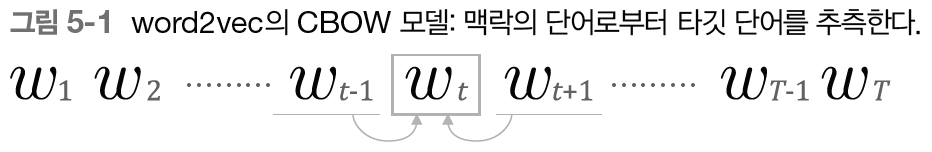
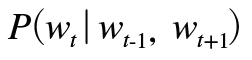
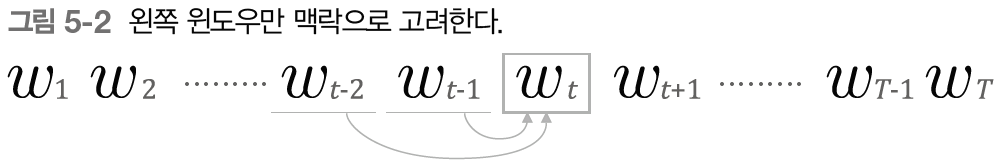
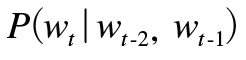

#### 5.1.2 언어 모델
#### - 언어 모델 : 단어 나열에 확률을 부여 / 특정한 단어의 시퀀스에 대해서 해당 시퀀스가 일어날 가능성이 어느정도인지 확률로 평가
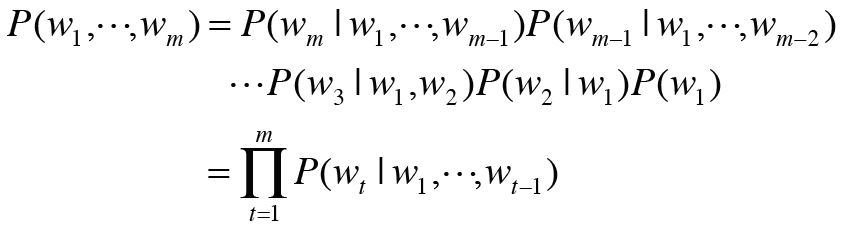
#### - 동시확률 = 사후 확률(타깃 단어보다 왼쪽에 있는 모든 단어를 맥락으로 했을 때의 확률)의 총곱
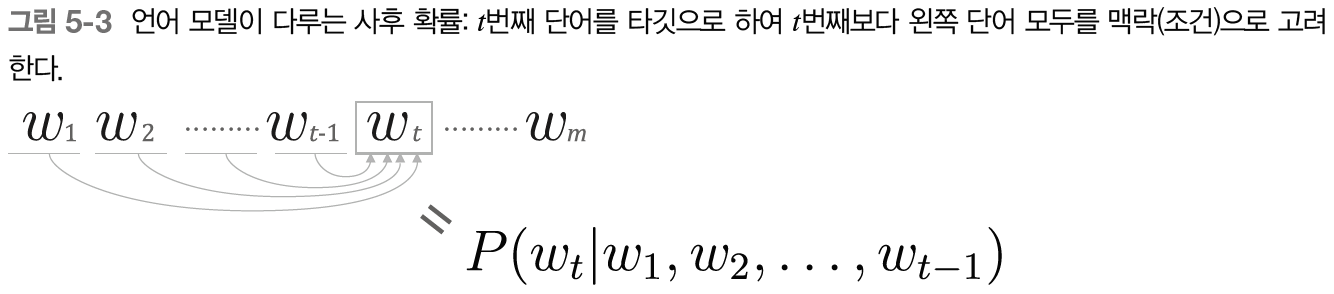

#### 5.1.3 CBOW 모델을 언어 모델로?
#### - 맥락의 크기를 특정 값으로 한정하여 근사적으로 언어모델로 표현 가능
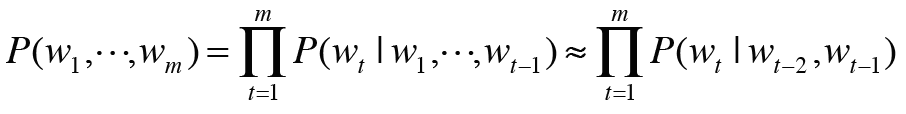
#### - 마르코프 연쇄, 마르코프 모델 : 미래의 상태가 현재 상태에만 의존하여 결정
#### - CBOW 모델에서는 맥락 안의 단어 순서가 무시된다는 한계 존재

### 5.2 RNN이란
#### - RNN = Recurrent Neural Network : 순환 신경망 != Recursive Neural Network(재귀 신경망) - 트리 구조 데이터를 처리
#### 5.2.1 순환하는 신경망
#### - 순환을 위해 닫힌 경로가 필요 / 데이터가 순환하면서 정보가 끊임없이 갱신
#### - 데이터가 순환되기 때문에 과거의 정보를 기억하는 동시에 최신 데이터로 갱신
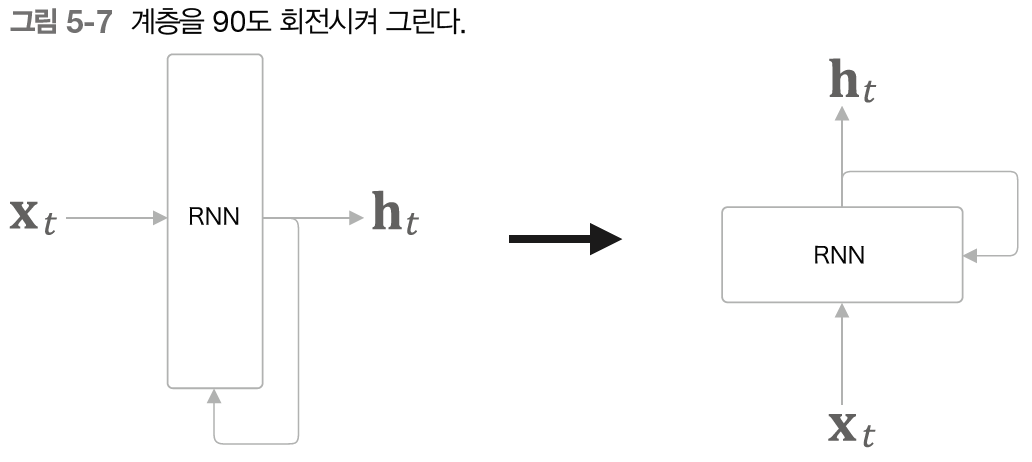

#### 5.2.2 순환 구조 펼치기
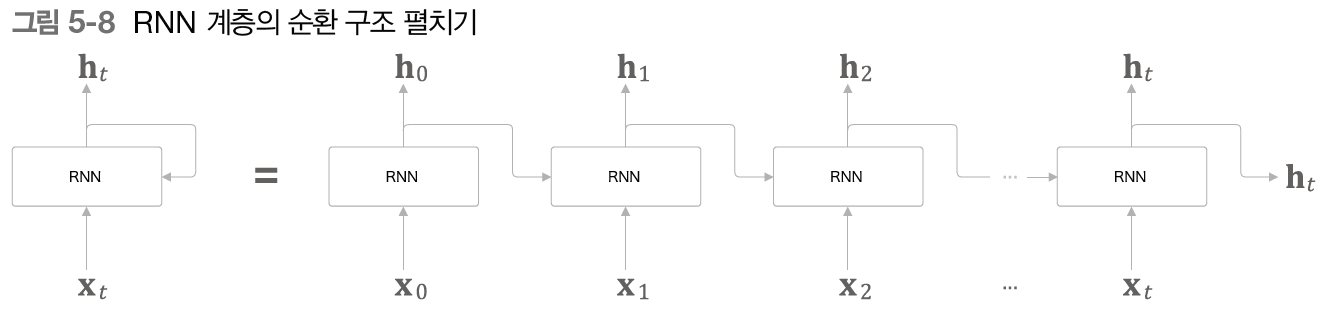
#### - RNN 계층의 input : 해당 시각의 입력 + 1개 전의 RNN 계층의 출력
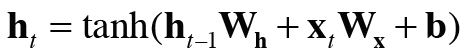
#### - 현재의 출력 h(은닉 상태, 은닉 상태 벡터)는 이전의 출력 h를 기초로 계산되기 때문에 h라는 상태를 지닌 채로 갱신 -> 상태를 지니는 계층, 메모리가 있는 계층

#### 5.2.3 BPTT
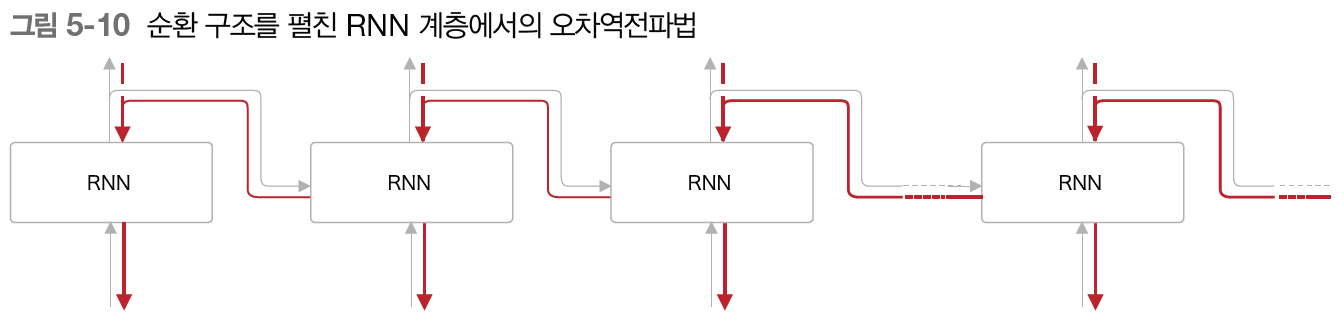
#### - BPTT = Backpropagation Through Time : 시간 방향으로 펼친 신경망의 오차역전파법
#### - 시계열 데이터의 시간 크기가 커지는 것에 비례하여 BPTT가 소비하는 컵퓨팅 자원도 증가 / 시간 크기가 커지면 역전파 시의 기울기가 불안정해지는 문제 발생

#### 5.2.4 Truncated BPTT
#### - 큰 시계열 데이터를 취급할 때는 흔히 신경망 연결을 적당한 길이로 절단 / 적당한 지점에서 잘라내여 작은 신경망 여러 개로 만든 후 오차역전법 수행 = Truncated BPTT
#### - 제대로 된 구현을 위해서는 역전파의 연결만 끊어야 함 / 순전파는 유지
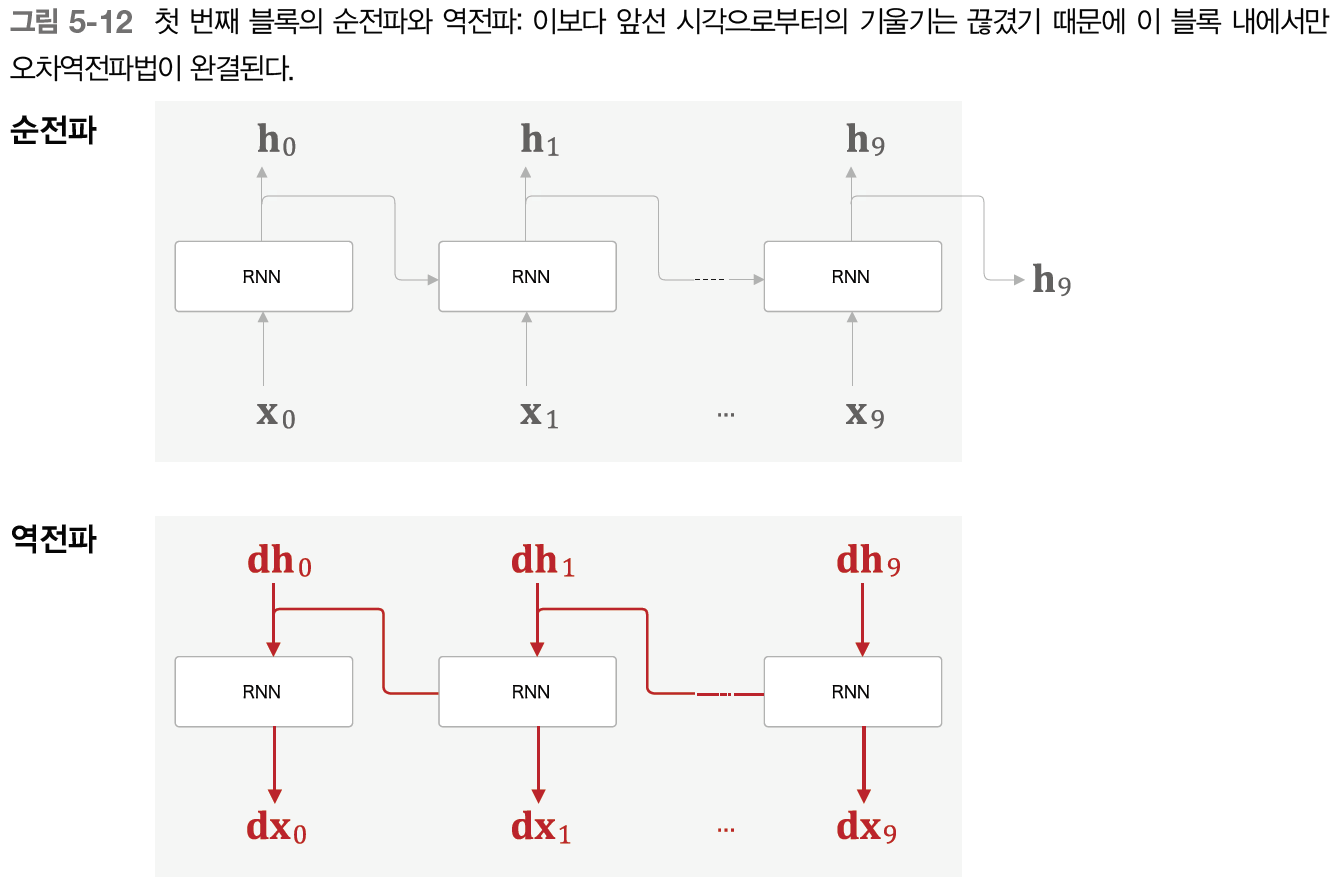
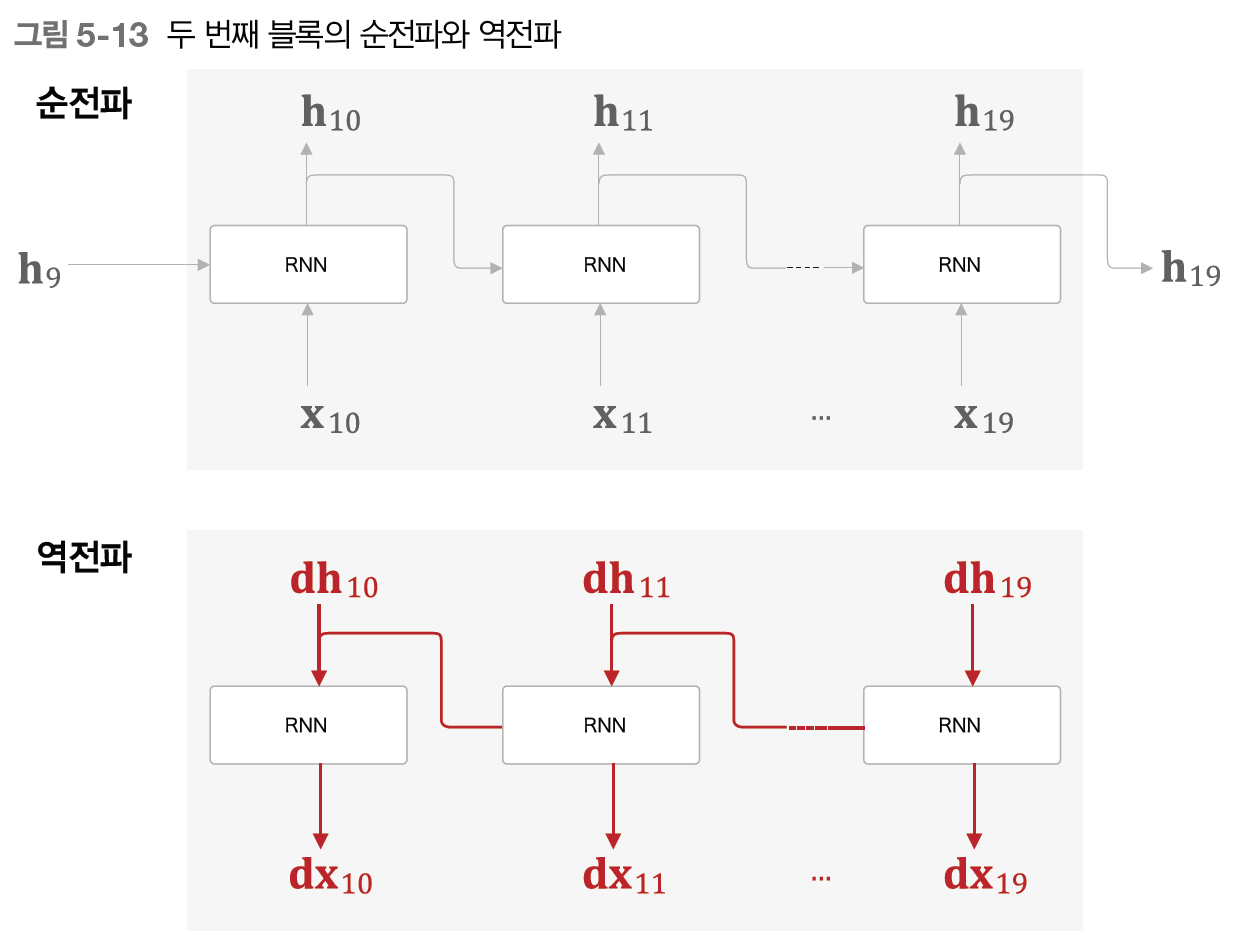
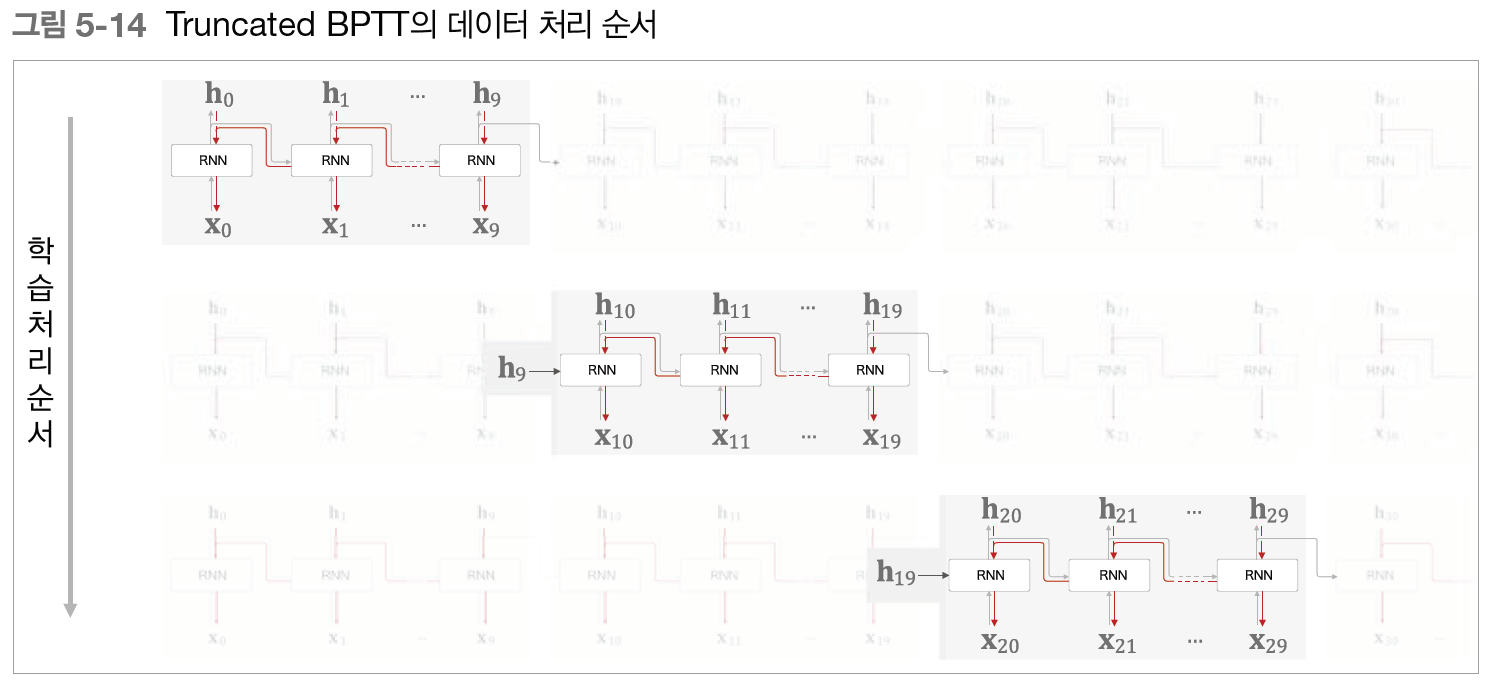

#### 5.2.5 Truncated BPTT의 미니배치 학습
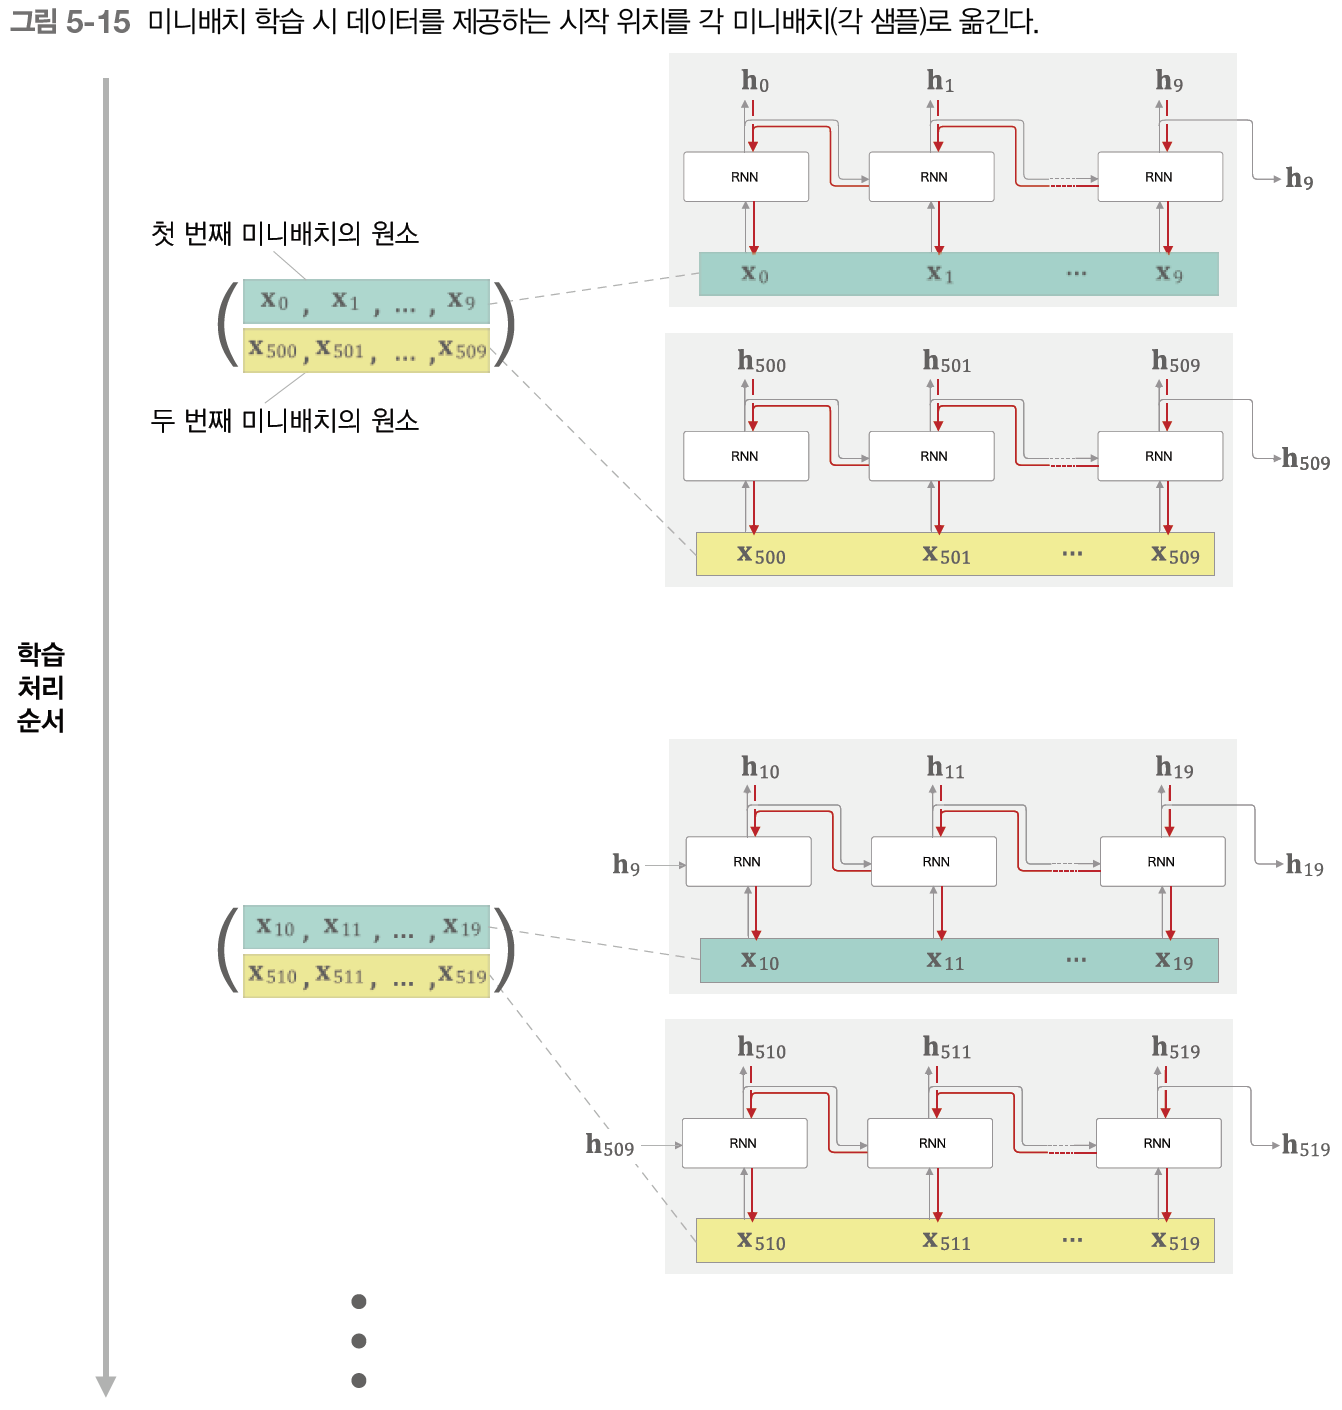

### 5.3 RNN 구현
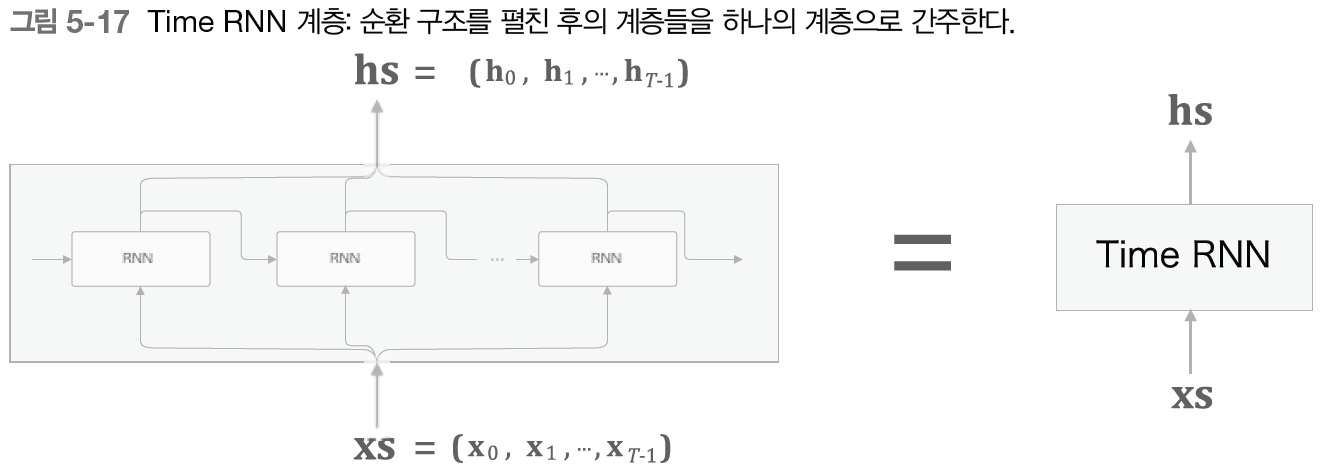
#### 5.3.1 RNN 계층 구현
#### - RNN 순전파 식
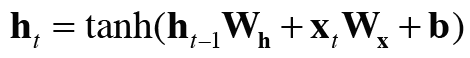
#### - 미니배치 크기 = N / 입력 베터 차원 수 = D / 은닉 상태 벡터 차원 수 = H
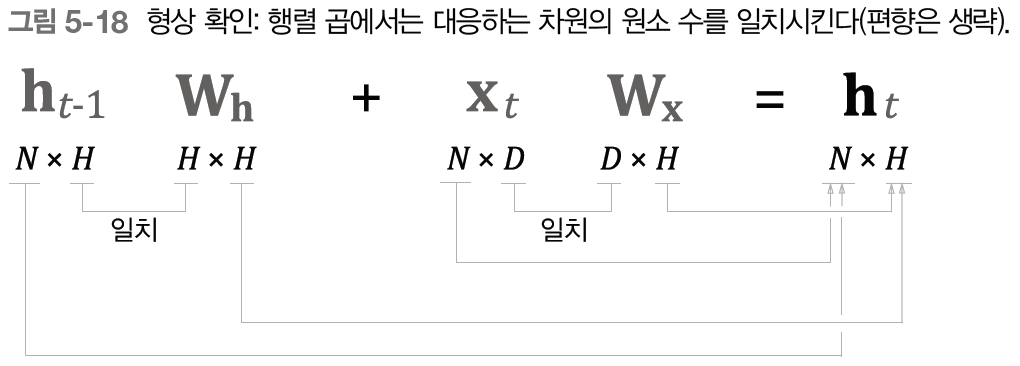
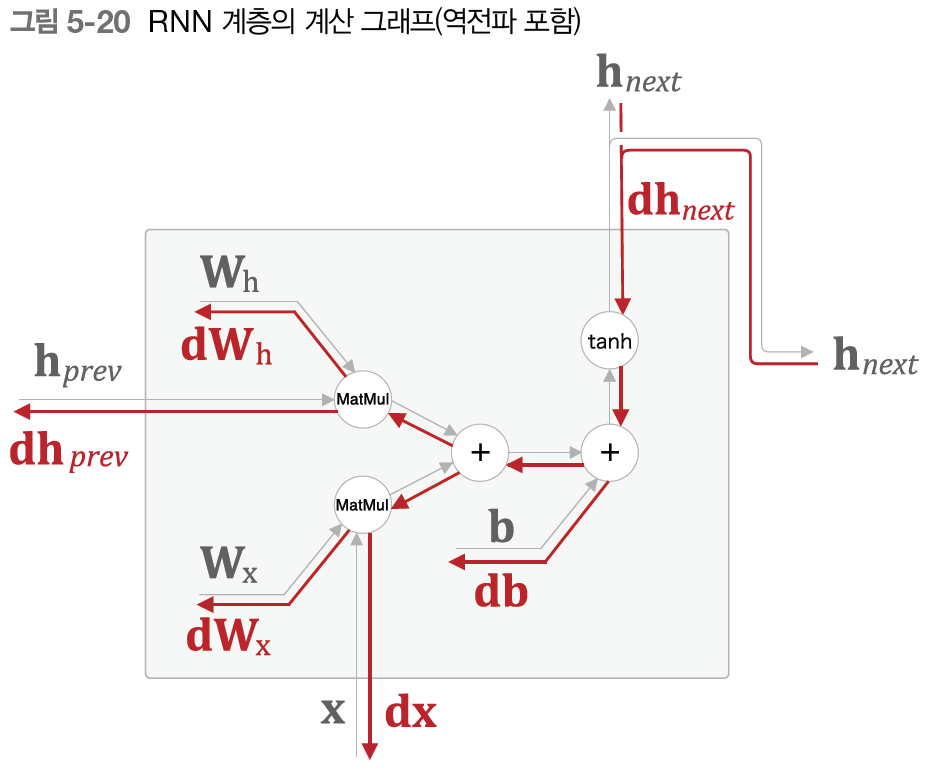

In [2]:
import numpy as np

class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)
        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1-h_next**2)
        db = np.sum(dt, axis=0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

#### 5.3.2 Time RNN 계층 구현
#### - T개의 RNN 계층
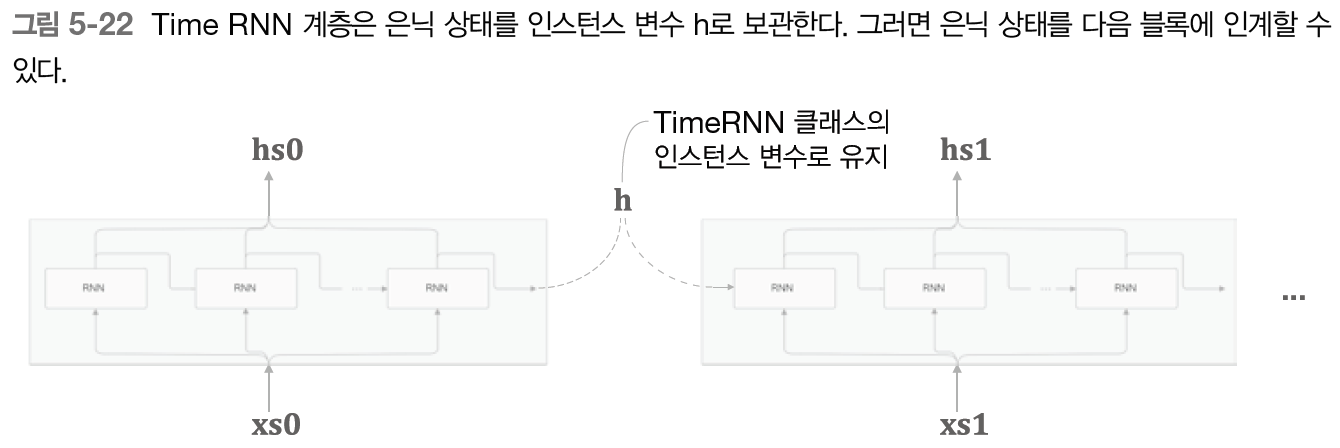
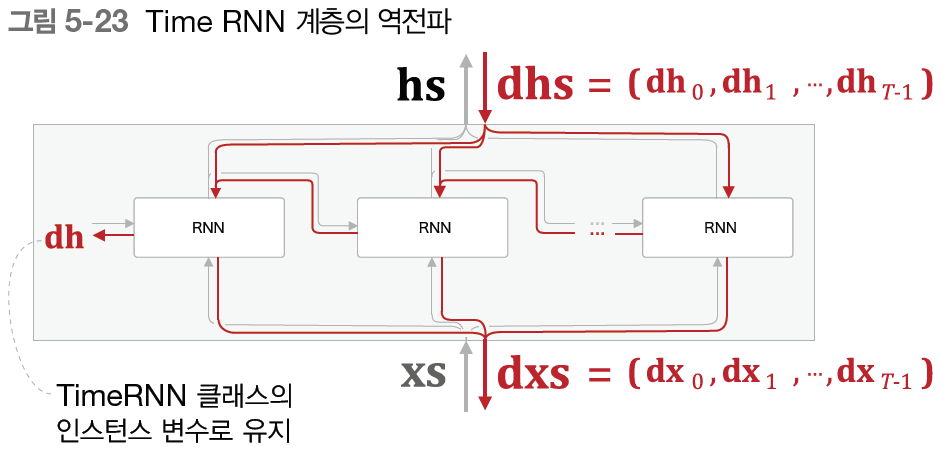

In [4]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.dh = None, None
        self.stateful = stateful
        
    def set_state(self, h):
        self.h = h
    def reset_state(self):
        self.h = None
    
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N,H), dtype='f')
        
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, D = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh =0
        grads =[0,0,0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

### 5.4 시계열 데이터 처리 계층 구현
#### 5.4.1 RNNLM의 전체 그림
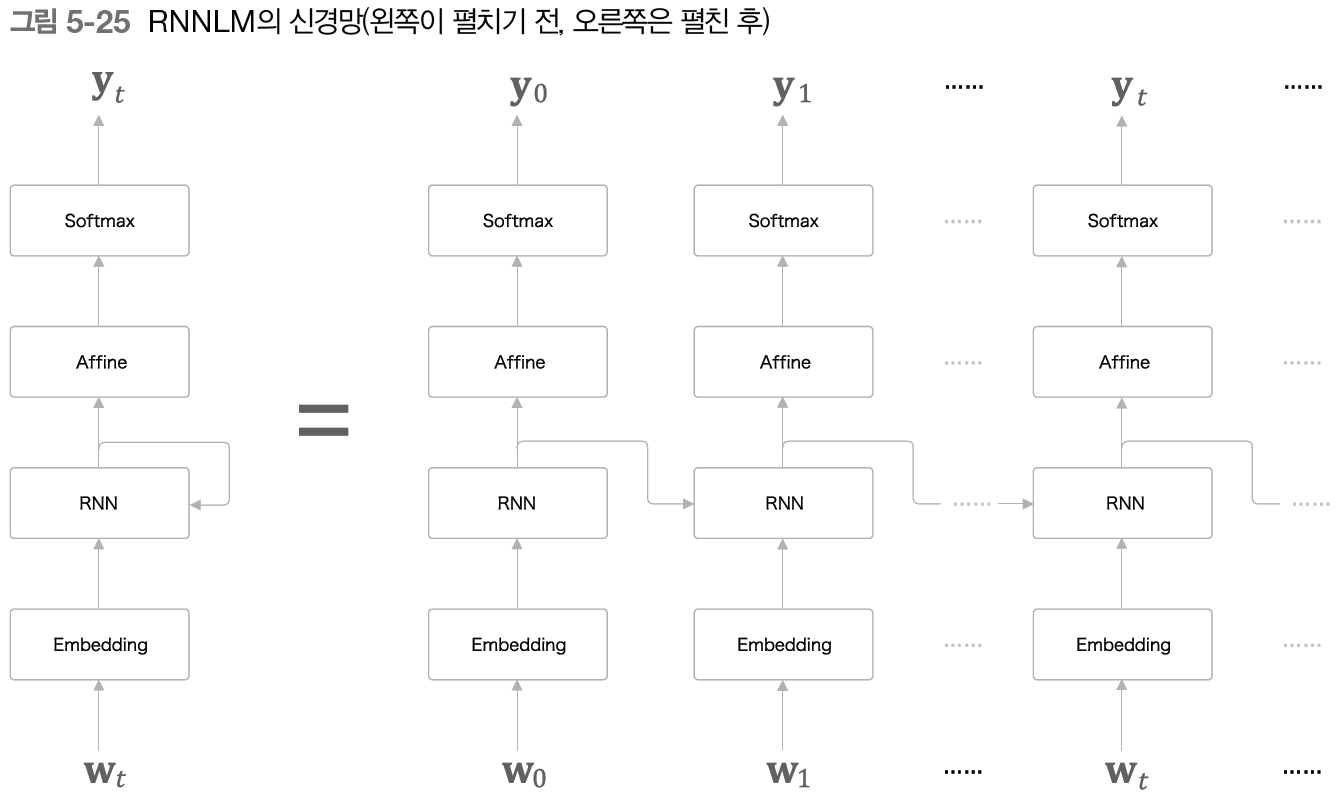
#### - RNNLM은 지금까지 입력된 단어를 기억하고, 그것을 바탕으로 다음에 출현할 단어를 예측 / RNN 계층이 과거에서 현재로 데이터를 계속 흘려보내줌으로써 과거의 정보를 인코딩해 저장할 수 있음

#### 5.4.2 Time 계층 구현
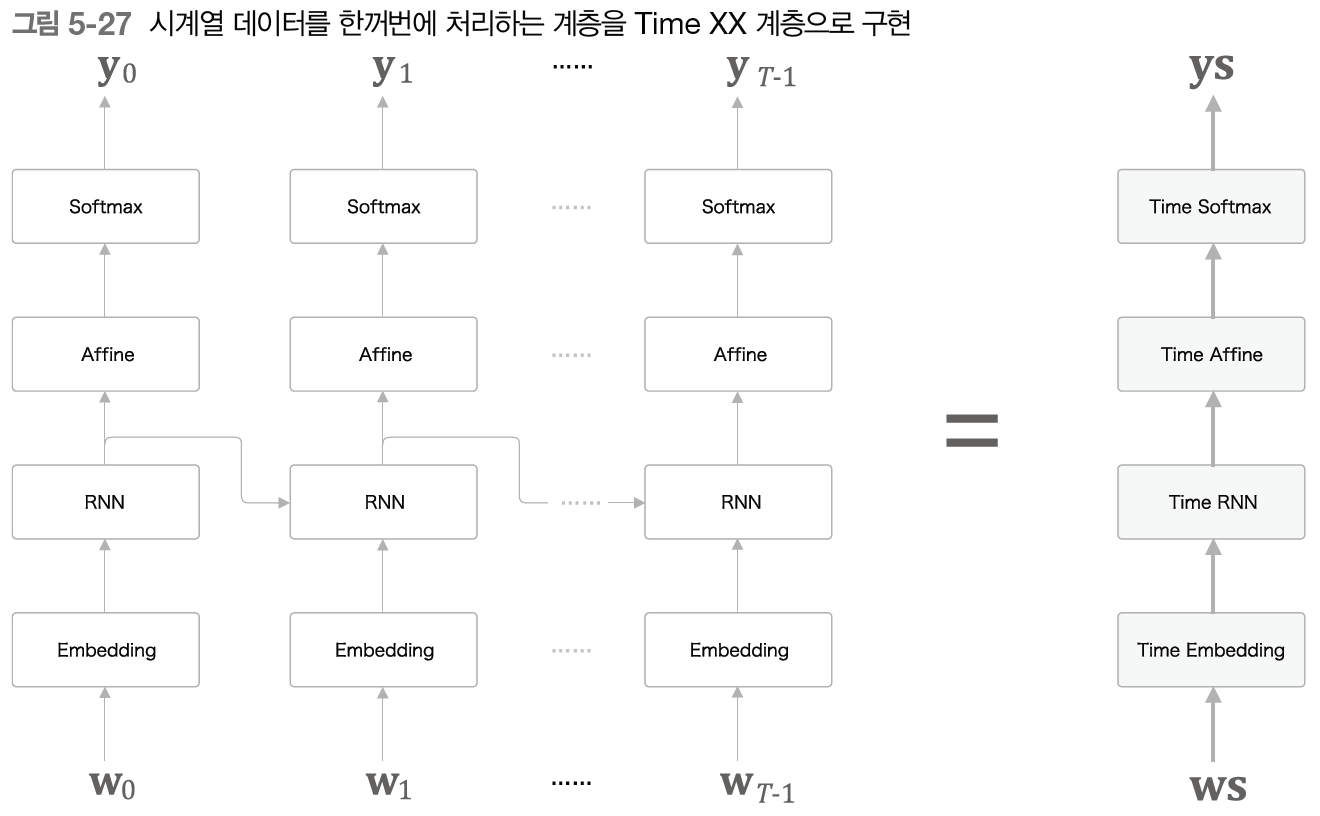
#### - Time Affine : Affine T개 준비해서 각 시각의 데이터를 개별로 처리
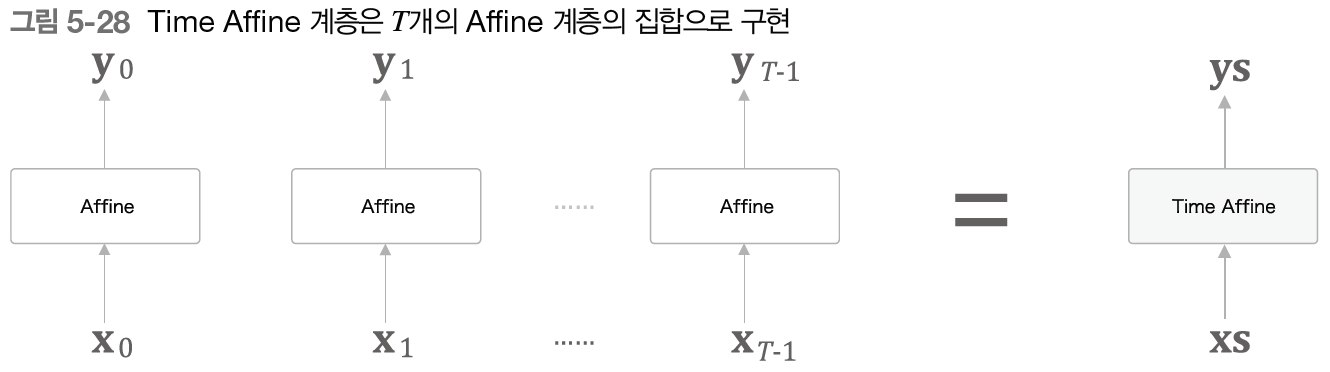
#### - Time Softmax with Loss
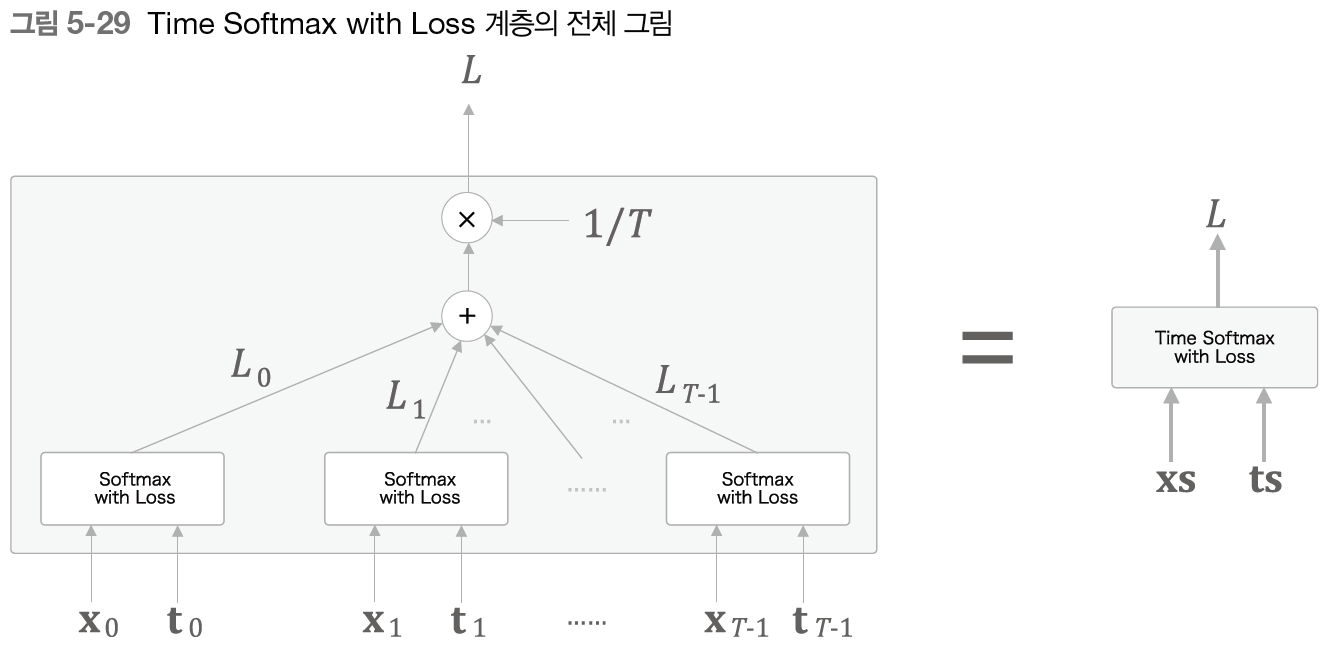

### 5.5 RNNLM 학습과 평가
#### 5.5.1 RNNLM 구현
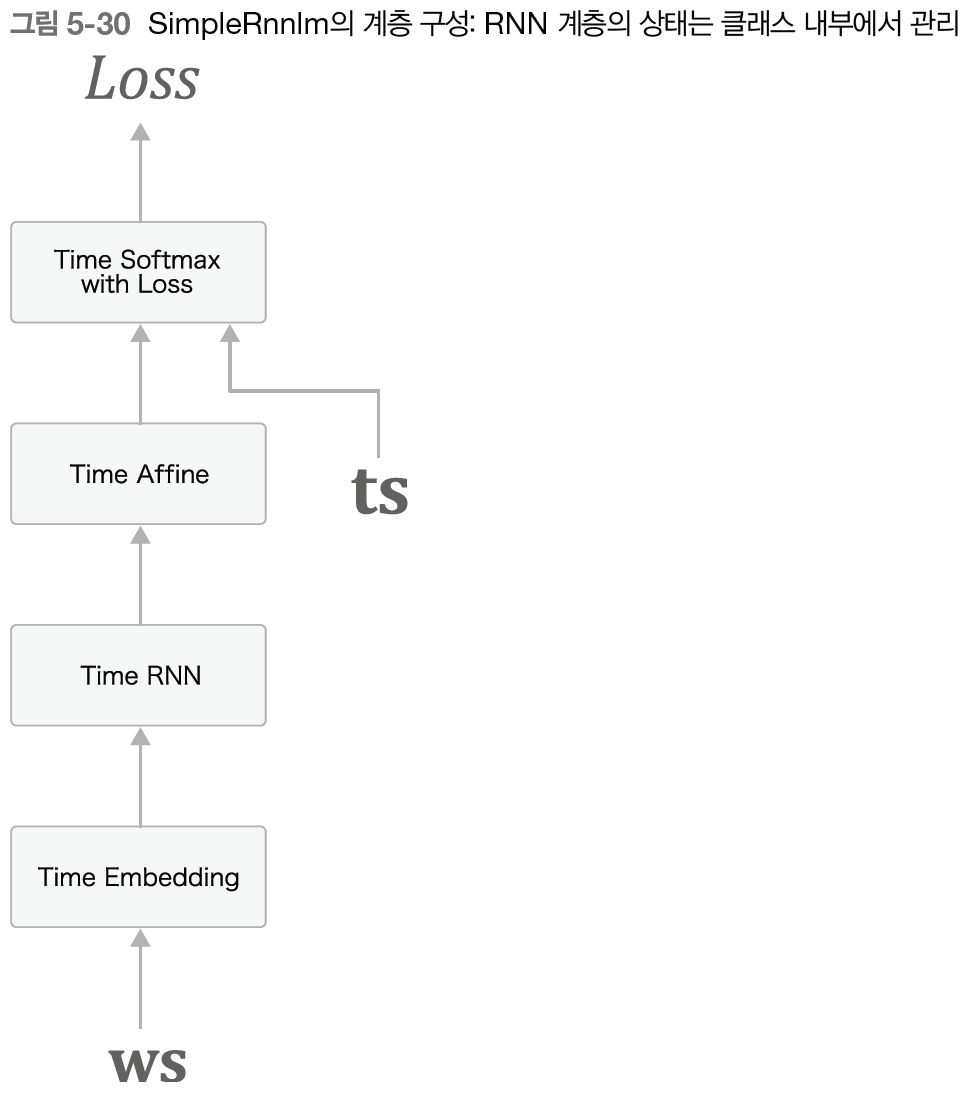
#### 5.5.2 언어 모델의 평가
#### - Perplexity(퍼플렉서티, 혼란도) : 확률의 역수 = 분기수(number of branches) = 다음에 취할 수 있는 선택사항의 수(다음에 출현할 수 있는 단어의 후보 수) 
#### - 좋은 모델일 수록 perplexity 값은 작음
#### - 입력 데이터가 여러개일 때
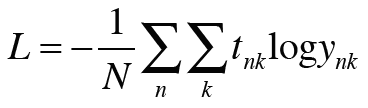
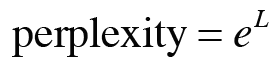

#### 5.5.3 RNNLM의 학습 코드
#### 5.5.4 RNNLM의 Trainer 클래스